<a href="https://colab.research.google.com/github/tomasborrella/TheValley/blob/main/notebooks/mds%2B5/spark03/2_Ejercicio_Resuelto_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejercicio resuelto de Pipeline

Notebook por [Tomás Borrella Martín](https://www.linkedin.com/in/tomasborrella/)
.
Ejemplos de [AnalyticsVidhya](https://www.analyticsvidhya.com/blog/2019/11/build-machine-learning-pipelines-pyspark/).

### Enlaces de interés
*   [Slides de presentación](https://docs.google.com/presentation/d/176cobMzuzy_mRRe3YumHBoap98PvFNXhhgIxN1mYmH0/edit?usp=sharing)

# Ejercicio

Partiendo del siguiente DataFrame:


```
df_train = spark.createDataFrame([
    (2.0, 'A', 'S10', 40, 1.0),
    (1.0, 'X', 'E10', 25, 1.0),
    (4.0, 'X', 'S20', 10, 0.0),
    (3.0, 'Z', 'S10', 20, 0.0),
    (4.0, 'A', 'E10', 30, 1.0),
    (2.0, 'Z', 'S10', 40, 0.0),
    (5.0, 'X', 'D10', 10, 1.0),
], ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'label'])
```

Crear el Pipeline que se muestran en la siguiente imagen:

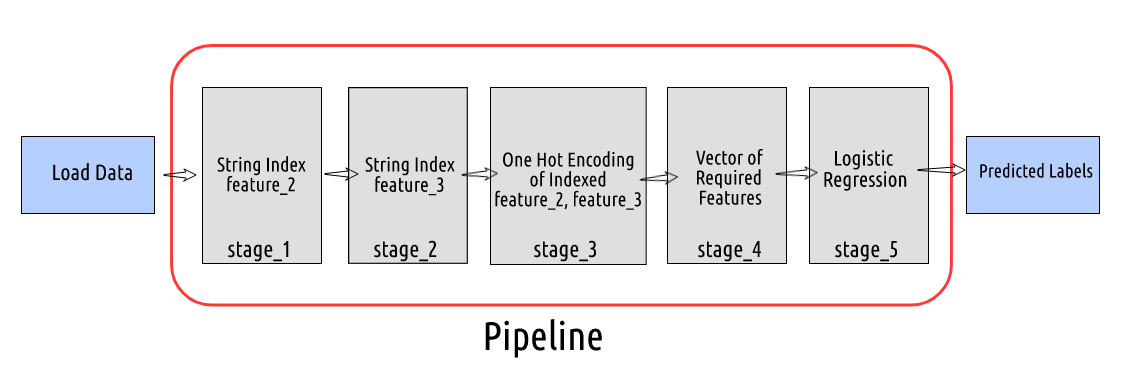

Y utilizar el Pipeline entrenado para predecir las 'label' del siguiente DataFrame:


```
df_test = spark.createDataFrame([
    (3.0, 'Z', 'S10', 40),
    (1.0, 'X', 'E10', 20),
    (4.0, 'A', 'S20', 10),
    (3.0, 'A', 'S10', 20),
    (4.0, 'X', 'D10', 30),
    (1.0, 'Z', 'E10', 20),
    (4.0, 'A', 'S10', 30),
], ['feature_1', 'feature_2', 'feature_3', 'feature_4'])
```


# 1. Instalación Spark

In [1]:
# Install JAVA
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
# Install Spark
!wget -q https://downloads.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop2.7.tgz
!tar xf spark-3.2.4-bin-hadoop2.7.tgz

In [3]:
# Install findspark
!pip install -q findspark

In [4]:
# Environment variables
import os 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.4-bin-hadoop2.7"

In [5]:
# Find spark
import findspark
findspark.init()

In [ ]:
# PySpark 
!pip install pyspark==3.2.4

# 2. Spark Session
Punto de entrada de la aplicación de Spark

In [7]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression

In [8]:
# Create Spark Session
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("Spark Dataframes")
         .getOrCreate()
)

## Cargar datos

In [ ]:
df_train = spark.createDataFrame([
    (2.0, 'A', 'S10', 40, 1.0),
    (1.0, 'X', 'E10', 25, 1.0),
    (4.0, 'X', 'S20', 10, 0.0),
    (3.0, 'Z', 'S10', 20, 0.0),
    (4.0, 'A', 'E10', 30, 1.0),
    (2.0, 'Z', 'S10', 40, 0.0),
    (5.0, 'X', 'D10', 10, 1.0),
], ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'label'])

df_train.show()

## Crear Pipeline

In [ ]:
# define stage 1: transform the column feature_2 to numeric
stage_1 = StringIndexer(inputCol= 'feature_2', outputCol= 'feature_2_index')

# define stage 2: transform the column feature_3 to numeric
stage_2 = StringIndexer(inputCol= 'feature_3', outputCol= 'feature_3_index')

# define stage 3: one hot encode the numeric versions of feature 2 and 3 generated from stage 1 and stage 2
stage_3 = OneHotEncoder(inputCols=[stage_1.getOutputCol(), stage_2.getOutputCol()], 
                        outputCols= ['feature_2_encoded', 'feature_3_encoded'])

# define stage 4: create a vector of all the features required to train the logistic regression model 
stage_4 = VectorAssembler(inputCols=['feature_1', 'feature_2_encoded', 'feature_3_encoded', 'feature_4'],
                          outputCol='features')

# define stage 5: logistic regression model                          
stage_5 = LogisticRegression(featuresCol='features',labelCol='label')

# setup the pipeline
regression_pipeline = Pipeline(stages= [stage_1, stage_2, stage_3, stage_4, stage_5])

# fit the pipeline for the trainind data
model = regression_pipeline.fit(df_train)

# transform the data
df_train = model.transform(df_train)

# view some of the columns generated
df_train.select('feature_1', 'features', 'label', 'rawPrediction', 'probability', 'prediction').show()

## Predecir sobre datos de test

In [11]:
df_test = spark.createDataFrame([
    (3.0, 'Z', 'S10', 40),
    (1.0, 'X', 'E10', 20),
    (4.0, 'A', 'S20', 10),
    (3.0, 'A', 'S10', 20),
    (4.0, 'X', 'D10', 30),
    (1.0, 'Z', 'E10', 20),
    (4.0, 'A', 'S10', 30),
], ['feature_1', 'feature_2', 'feature_3', 'feature_4'])

In [ ]:
df_test.show()

In [ ]:
# transform the data using the pipeline
df_test = model.transform(df_test)

# see the prediction on the test data
df_test.select('feature_1', 'features', 'rawPrediction', 'probability', 'prediction').show()

# Spark Stop

In [14]:
spark.stop()